<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Data_analysis3_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the third dataset (noisy version)

In [11]:
#@title
import zipfile
import io
import cv2
import glob 
import numpy as np
import random 
import torch 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive

torch.manual_seed(0) # Reproducible, for now 

FIGSIZE = (12,10)

!rm -rf main_dir
!rm -rf data.zip

drive.mount('/content/drive/')
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data3/random.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
transf = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)

val_data = ImageFolder(root = os.path.join(root_dir, 'val'), transform = transf)

test_data = ImageFolder(root = os.path.join(root_dir, 'test'), transform = transf)

idx_to_class = {j:i for i,j in train_data.class_to_idx.items()}


# Dataset description 


*   Label 0: the image doesn't contain any shape 
*   Label 1: the image contains at least one shape 
Here are two examples: 



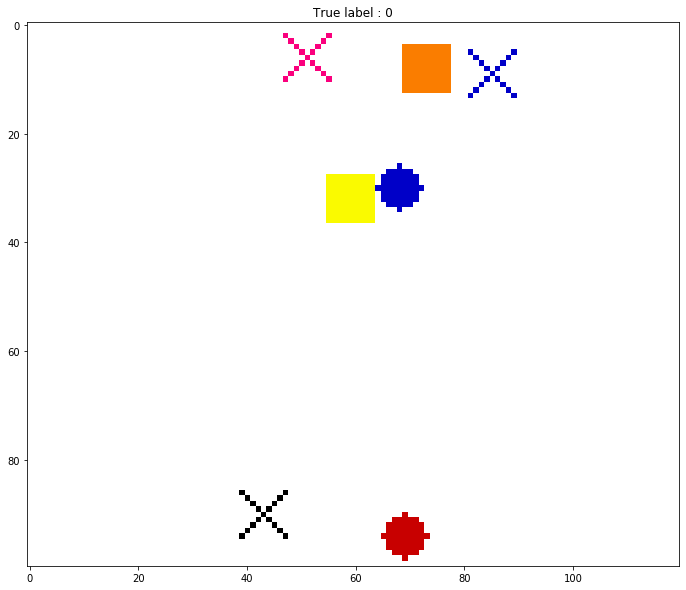

In [13]:
#@title
def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[true_label]
  
  if (predicted_label != None):
    title_ += "/ Predicted : " + idx_to_class[predicted_label]


  plt.title(title_)

display_image(train_data[0][0], train_data[0][1])

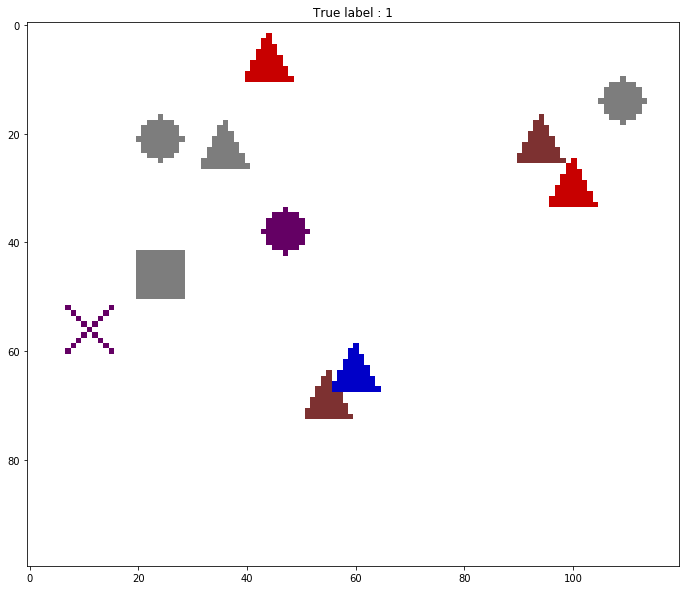

In [14]:
display_image(train_data[-1][0], train_data[-1][1])

In [0]:
#@title
batch_Size = 64
dataloader = DataLoader(train_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
valloader = DataLoader(val_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
testloader = DataLoader(test_data, batch_size = batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
x,y = next(train_loader)

# Model description
The neural network used to classify the images receives batches of 3x100x120 images. 
It consists of 
* two convolutional layers followed by max pooling 
* three fully connected layers

In [0]:
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 4)
    self.pool2 = nn.MaxPool2d(5)
    self.fc1 = nn.Linear(16 * 9 * 11, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters()) # , lr=1e-4, eps=5e-7)

In [21]:
max_epochs = 50
converged = False
epsilon = 0.0001

def almost_equal(n1, n2, e): 
  return abs(n1-n2) < e

def training_accuracy(network, loader): 
  with torch.no_grad(): 
    correct = 0
    total = 0
    for data in loader: 
      images, labels = data             
      outputs = network(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct/total

def validation_stats(network, loader, crit): 
  total_loss = 0
  correct = 0
  total = 0
  with torch.no_grad(): 
    for data in loader: 
      images, labels = data             
      outputs = network(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      loss = criterion(outputs, labels)
      total_loss += loss.item()

  return (100 * correct/total, total_loss/len(loader.dataset))

def network_has_converged(loss, e): 
  if (len(loss) < 3):
    return False
  else: 
    return (almost_equal(loss[-3], loss[-2], e) and 
            almost_equal(loss[-3], loss[-1], e) )
          

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(max_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  if not converged: 
    for i, data in enumerate(dataloader, 0):
      
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # plot loss 
      running_loss += loss.item()

    
    train_loss.append(running_loss/len(dataloader.dataset))
    train_accuracy.append(training_accuracy(net, dataloader))
    A, L = validation_stats(net, valloader, criterion)
    val_loss.append(L)
    val_accuracy.append(A)

    print('Generation %d. training loss: %.4f,' 
          % (epoch + 1, train_loss[-1]), end = "")
    print(" training accuracy: %.2f " % (train_accuracy[-1]), end = "%,")
    print(" validation loss: %.4f," % (val_loss[-1]), end = " ")
    print(" validation accuracy: %.2f " % (val_accuracy[-1]), end="% \n")    

    converged = network_has_converged(train_loss, epsilon)
      
if (converged): 
  print ("Network has converged.")
else: 
  print("Network hasn't been able to converge in " + str(max_epochs) + " generations.")

Generation 1. training loss: 0.0101, training accuracy: 82.18 %, validation loss: 0.0066,  validation accuracy: 82.25 % 
Generation 2. training loss: 0.0013, training accuracy: 99.37 %, validation loss: 0.0004,  validation accuracy: 99.45 % 
Generation 3. training loss: 0.0004, training accuracy: 99.69 %, validation loss: 0.0003,  validation accuracy: 99.55 % 
Generation 4. training loss: 0.0002, training accuracy: 99.79 %, validation loss: 0.0003,  validation accuracy: 99.70 % 
Generation 5. training loss: 0.0002, training accuracy: 99.87 %, validation loss: 0.0002,  validation accuracy: 99.65 % 
Generation 6. training loss: 0.0004, training accuracy: 99.83 %, validation loss: 0.0002,  validation accuracy: 99.65 % 
Generation 7. training loss: 0.0001, training accuracy: 99.93 %, validation loss: 0.0001,  validation accuracy: 99.80 % 
Generation 8. training loss: 0.0001, training accuracy: 99.95 %, validation loss: 0.0002,  validation accuracy: 99.80 % 
Generation 9. training loss: 0.0

Text(0, 0.5, 'Evaluation of the loss function')

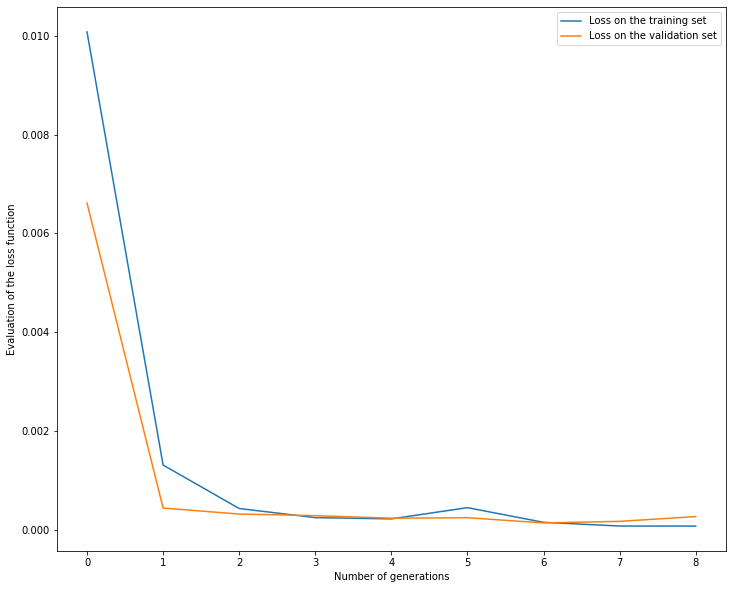

In [22]:
plt.figure(figsize = FIGSIZE)
x_scale = np.linspace(0, len(train_loss)- 1, len(train_loss) )
_ = plt.plot(x_scale, train_loss)
_ = plt.plot(x_scale, val_loss)
plt.legend(["Loss on the training set", "Loss on the validation set"])
plt.xlabel("Number of generations")
plt.ylabel("Evaluation of the loss function")

Text(0, 0.5, 'Accuracy ')

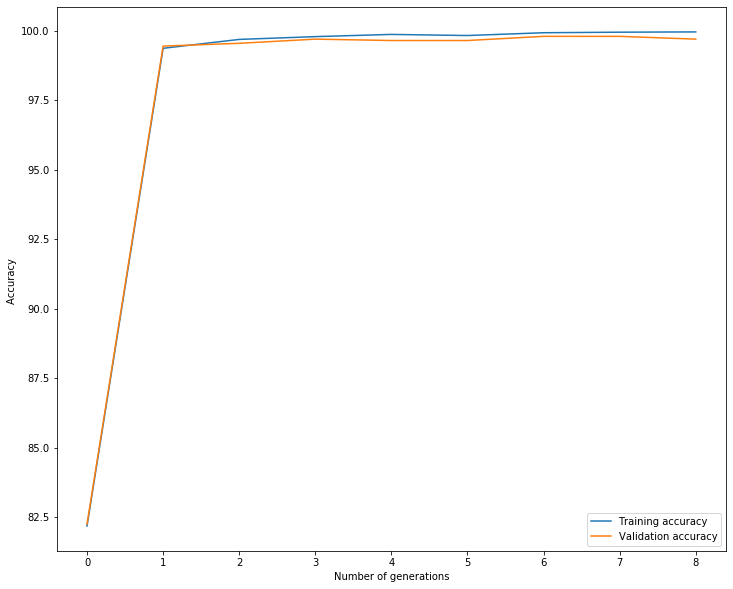

In [23]:
plt.figure(figsize = FIGSIZE)
x_scale = np.linspace(0, len(train_accuracy)- 1, len(train_accuracy) )
_ = plt.plot(x_scale, train_accuracy)
_ = plt.plot(x_scale, val_accuracy)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.xlabel("Number of generations")
plt.ylabel("Accuracy ")

In [0]:
def test(loader):
  correct = 0
  total = 0
  wrong_im = []
  wrong_label = []
  wrongly_predicted_label = []

  with torch.no_grad():
      for data in loader:
          images, labels = data

          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          k = 0
          for truth in (predicted == labels): 
            if not truth: 
              wrong_im.append(images[k])
              wrong_label.append(int(labels[k]))
              wrongly_predicted_label.append(int(predicted[k]))
            k += 1
          
          

  print("Accuracy of the network on the " + str(total) + ' test images: %.3f %%' % (
      100 * correct / total))

  print("Number of mistakes : " +str(total-correct))
  return wrong_im, wrong_label, wrongly_predicted_label

In [25]:
wi, wl, wpl = test(testloader)
index = 0

Accuracy of the network on the 4000 test images: 99.500 %
Number of mistakes : 20


Score for predicted label:  3.9500587
Score for true label:  -3.9697716


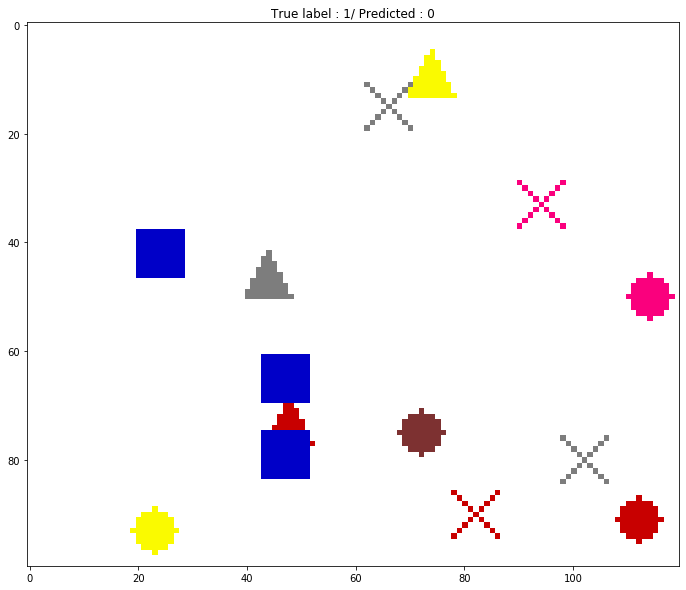

In [29]:
if index in range(len(wi)):
  display_image(wi[index], wl[index], wpl[index])
  outputs = net(wi[index].unsqueeze(0)).data
  print("Score for predicted label: ", outputs.numpy()[0][wpl[index]])
  print("Score for true label: ", outputs.numpy()[0][wl[index]])
  index += 1

In [27]:
save = input("Overwrite current state dictionnary ? [y/n]")
if (save == 'y'): 
  torch.save(net.state_dict(), 'drive/My Drive/Interpretability/model3_random.pth')
  print("State dictionnary saved.")
else: 
  print("State dictionnary has not been saved.")

Overwrite current state dictionnary ? [y/n]y
State dictionnary saved.
